In [15]:
# Task 1.
# Текстурные характеристики:
#  - Реализуйте подсчет гистограммы 
#  - Реализуйте рассчет текстурных характеристик Laws 
#  - Реализуйте расчет текстурных характеристик на основе матрицы взаимной встречаемости GLCM
# Для каждого случая: выполните тренировку классификатора (knn, svm, trees)
# Решите задачу сегментации данных на основе классификации изображений каждым методом.
# Выполните ручную разметку изображений на регионы.
# Сравните результат полученной классификации и размеченной.

=== ЗАГРУЗКА ИЗОБРАЖЕНИЯ ===


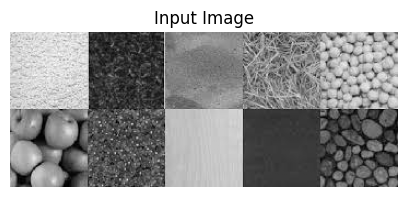


=== 1. Histogram Features ===


ValueError: operands could not be broadcast together with shapes (256,) (257,) (256,) 

In [16]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy, skew, kurtosis
from skimage.feature import graycomatrix, graycoprops
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, jaccard_score

# -----------------------
# 1) Гистограмма
# -----------------------
def extract_hist_features(img: np.ndarray, n_bins: int = 256):
    flat = img.flatten()
    hist, _ = np.histogram(flat, bins=n_bins, range=(0, 256))
    hist = hist.astype(float)
    hist_norm = hist / hist.sum() if hist.sum() > 0 else hist
    bin_w = 256.0 / n_bins
    centers = (np.arange(n_bins) + 0.5) * bin_w
    repeated = np.repeat(centers, np.maximum(hist.round().astype(int), 0))
    stats = {
        "mean": float(np.average(centers, weights=hist) if hist.sum() > 0 else 0.0),
        "variance": float(np.var(repeated) if repeated.size > 0 else 0.0),
        "std": float(np.std(repeated) if repeated.size > 0 else 0.0),
        "skewness": float(skew(repeated)) if repeated.size > 0 else 0.0,
        "kurtosis": float(kurtosis(repeated)) if repeated.size > 0 else 0.0,
        "energy": float(np.sum(hist_norm ** 2)),
        "entropy": float(entropy(hist_norm)) if hist_norm.sum() > 0 else 0.0,
        "median": float(np.median(flat)),
        "q25": float(np.percentile(flat, 25)),
        "q75": float(np.percentile(flat, 75)),
        "min": int(flat.min()),
        "max": int(flat.max()),
        "contrast": int(flat.max()) - int(flat.min())
    }
    return stats, hist_norm

# -----------------------
# 2) Laws texture
# -----------------------
def laws_energy(img: np.ndarray):
    masks_1d = [
        (np.array([1,4,6,4,1], dtype=np.float32), "L5"),
        (np.array([-1,-2,0,2,1], dtype=np.float32), "E5"),
        (np.array([-1,0,2,0,-1], dtype=np.float32), "S5"),
        (np.array([-1,2,0,-2,1], dtype=np.float32), "W5"),
        (np.array([1,-4,6,-4,1], dtype=np.float32), "R5")
    ]
    img_f = img.astype(np.float32)
    feats = {}
    for a, name_a in masks_1d:
        for b, name_b in masks_1d:
            kern = np.outer(a,b)
            response = cv2.filter2D(img_f, ddepth=cv2.CV_32F, kernel=kern)
            feats[f"{name_a}{name_b}"] = float(np.mean(response**2))
    total = sum(feats.values())
    if total > 0:
        for k in feats.keys():
            feats[k] /= total
    return feats

# -----------------------
# 3) GLCM
# -----------------------
def glcm_features(img: np.ndarray, distances=[1], angles=None, levels=32):
    if angles is None:
        angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    q = np.clip((img.astype(int)*levels)//256, 0, levels-1).astype(np.uint8)
    glcm = graycomatrix(q, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)
    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    out = {}
    for p in props:
        try:
            val = graycoprops(glcm, p)
            out[p] = float(np.mean(val))
        except Exception:
            out[p] = 0.0
    return out

# -----------------------
# Построение вектора признаков
# -----------------------
def build_feature_vector(img: np.ndarray, mode: str):
    if mode == 'hist':
        stats, _ = extract_hist_features(img, n_bins=32)
        return list(stats.values())
    elif mode == 'laws':
        feats = laws_energy(img)
        return list(feats.values())
    elif mode == 'glcm':
        feats = glcm_features(img)
        return list(feats.values())
    else:
        raise ValueError("mode must be 'hist','laws','glcm'")

# -----------------------
# Подготовка данных для одного изображения
# -----------------------
def prepare_data_single(image_path: str, label: str, feature_mode: str, resize_to=(128,128)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(image_path)
    img = cv2.resize(img, resize_to)
    features = build_feature_vector(img, feature_mode)
    X = np.array([features], dtype=float)
    y = [label]
    return X, y

# -----------------------
# Обучение классификаторов
# -----------------------
def train_classifiers(X, y):
    y_enc = LabelEncoder().fit_transform(y)
    X_tr, X_te, y_tr, y_te = train_test_split(X, y_enc, test_size=0.25, random_state=42, stratify=y_enc)
    scaler = StandardScaler()
    X_tr_s = scaler.fit_transform(X_tr)
    X_te_s = scaler.transform(X_te)
    classifiers = {
        "knn": KNeighborsClassifier(n_neighbors=3),
        "svm": SVC(kernel='rbf'),
        "tree": DecisionTreeClassifier(max_depth=10, random_state=42)
    }
    fitted = {}
    stats = {}
    for name, clf in classifiers.items():
        clf.fit(X_tr_s, y_tr)
        fitted[name] = clf
        y_pred = clf.predict(X_te_s)
        acc = accuracy_score(y_te, y_pred)
        report = classification_report(y_te, y_pred, output_dict=True, zero_division=0)
        stats[name] = {"model": clf, "accuracy": float(acc), "f1_macro": float(report.get("macro avg",{}).get("f1-score",0))}
    return fitted, scaler, stats

# -----------------------
# Сегментация изображения
# -----------------------
def segment_image_by_texture(img_path, model, scaler, feature_mode, win=32, step=None, top_k=4):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if step is None:
        step = win
    h,w = img.shape
    result_map = np.zeros((h,w), dtype=np.int32)
    predictions = []
    for y in range(0,h-win+1,step):
        for x in range(0,w-win+1,step):
            patch = img[y:y+win, x:x+win]
            feats = np.array(build_feature_vector(patch, feature_mode),dtype=float).reshape(1,-1)
            feats_s = scaler.transform(feats)
            pred = int(model.predict(feats_s)[0])
            result_map[y:y+win, x:x+win] = pred
            predictions.append(pred)
    unique, counts = np.unique(predictions, return_counts=True)
    order = np.argsort(counts)[::-1]
    top_classes = unique[order][:top_k]
    seg = np.zeros_like(result_map)
    for new_id, cls in enumerate(top_classes):
        seg[result_map == cls] = new_id
    return seg, img

# -----------------------
# Визуализация сегментации
# -----------------------
def show_segmentation(seg_map, original, title="Segmentation"):
    fig, ax = plt.subplots(1,3,figsize=(15,4))
    ax[0].imshow(original, cmap='gray'); ax[0].set_title("Original"); ax[0].axis('off')
    ax[1].imshow(seg_map, cmap='tab10'); ax[1].set_title(title); ax[1].axis('off')
    ax[2].imshow(original, cmap='gray'); ax[2].imshow(seg_map, cmap='tab10', alpha=0.5)
    ax[2].set_title("Overlay"); ax[2].axis('off')
    plt.show()

# -----------------------
# Ручная разметка
# -----------------------
def manual_mask_from_rgb(img_rgb):
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY) if img_rgb.ndim==3 else img_rgb
    _, th = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    if np.mean(gray[th==255]) < np.mean(gray[th==0]):
        th = 255-th
    contours,_ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(th,dtype=np.uint8)
    if contours:
        largest = max(contours, key=cv2.contourArea)
        cv2.drawContours(mask,[largest],-1,1,thickness=-1)
    return mask

def map_top_n_classes(mask, n=4):
    uniq, cnts = np.unique(mask, return_counts=True)
    idx = np.argsort(cnts)[::-1][:n]
    top = uniq[idx]
    out = np.zeros_like(mask,dtype=np.uint8)
    for new_id, val in enumerate(top):
        out[mask==val] = new_id
    return out

# -----------------------
# Сравнение сегментаций
# -----------------------
def best_label_mapping(gt, pred):
    gt_flat = gt.flatten()
    pred_flat = pred.flatten()
    mapping = {}
    for p_val in np.unique(pred_flat):
        best_g = None
        best_overlap = -1
        for g_val in np.unique(gt_flat):
            overlap = np.sum((pred_flat==p_val) & (gt_flat==g_val))
            if overlap>best_overlap:
                best_overlap = overlap
                best_g = int(g_val)
        mapping[p_val]=best_g
    return mapping

def evaluate_segmentation(gt_mask, pred_mask, orig_img=None):
    if gt_mask.shape != pred_mask.shape:
        pred_mask = cv2.resize(pred_mask,(gt_mask.shape[1], gt_mask.shape[0]), interpolation=cv2.INTER_NEAREST)
    mapping = best_label_mapping(gt_mask, pred_mask)
    mapped = np.zeros_like(pred_mask)
    for p_val,g_val in mapping.items():
        mapped[pred_mask==p_val]=g_val
    acc = accuracy_score(gt_mask.flatten(), mapped.flatten())
    iou = jaccard_score(gt_mask.flatten(), mapped.flatten(), average=None, labels=np.unique(gt_mask))
    print(f"Overall accuracy: {acc:.4f}")
    print("IoU per class:")
    for cls_idx, score in zip(np.unique(gt_mask), iou):
        print(f"  class {cls_idx}: {score:.4f}")
    fig, axes = plt.subplots(1,3,figsize=(15,5))
    if orig_img is None:
        axes[0].imshow(gt_mask,cmap='gray')
        axes[0].set_title("Ground truth (mask)")
    else:
        axes[0].imshow(orig_img,cmap='gray')
        axes[0].set_title("Original image")
    axes[1].imshow(gt_mask,cmap='tab10'); axes[1].set_title("Ground truth"); axes[1].axis('off')
    axes[2].imshow(mapped,cmap='tab10'); axes[2].set_title("Prediction (mapped)"); axes[2].axis('off')
    axes[0].axis('off'); axes[1].axis('off'); axes[2].axis('off')
    plt.tight_layout(); plt.show()

# -----------------------
# Демонстрация с одним изображением
# -----------------------
def run_demo_single_image(image_path):
    print("=== ЗАГРУЗКА ИЗОБРАЖЕНИЯ ===")
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    plt.figure(figsize=(5,5))
    plt.imshow(img,cmap='gray'); plt.title("Input Image"); plt.axis('off'); plt.show()

    # 1. Гистограмма
    print("\n=== 1. Histogram Features ===")
    feats, hist = extract_hist_features(img)
    plt.figure(figsize=(5,5))
    plt.imshow(img,cmap='gray'); plt.title("Image"); plt.axis('off'); plt.show()
    plt.figure(figsize=(5,4)); plt.bar(range(len(hist)), hist); plt.title("Histogram"); plt.show()
    print("Histogram stats:")
    for k,v in feats.items(): print(f"{k}: {v:.4f}")

    # 2. Laws
    print("\n=== 2. Laws Features ===")
    feats_laws = laws_energy(img)
    plt.figure(figsize=(5,5))
    plt.imshow(img,cmap='gray'); plt.title("Image"); plt.axis('off'); plt.show()
    print("Top Laws features:")
    top = sorted(feats_laws.items(), key=lambda x:x[1], reverse=True)[:8]
    for k,v in top: print(f"{k}: {v:.5f}")

    # 3. GLCM
    print("\n=== 3. GLCM Features ===")
    feats_glcm = glcm_features(img)
    plt.figure(figsize=(5,5))
    plt.imshow(img,cmap='gray'); plt.title("Image"); plt.axis('off'); plt.show()
    for k,v in feats_glcm.items(): print(f"{k}: {v:.4f}")

    # 4. Обучение классификаторов
    print("\n=== 4. Train Classifiers ===")
    feature_mode = "hist"  # Выберите: 'hist', 'laws', 'glcm'
    X, y = prepare_data_single(image_path, "Texture1", feature_mode)
    models, scaler, stats = train_classifiers(X, y)
    for name, info in stats.items():
        print(f"{name}: accuracy={info['accuracy']:.3f}, f1={info['f1_macro']:.3f}")

    # 5. Сегментация
    print("\n=== 5. Segmentation ===")
    seg_map, orig_img = segment_image_by_texture(image_path, models["knn"], scaler, feature_mode, win=16, step=8)
    show_segmentation(seg_map, orig_img, title=f"Segmentation ({feature_mode} + KNN)")

    # 6. Ручная разметка
    print("\n=== 6. Manual Segmentation ===")
    img_rgb = cv2.imread(image_path)
    manual = manual_mask_from_rgb(img_rgb)
    manual = map_top_n_classes(manual, n=4)
    plt.figure(figsize=(5,5))
    plt.imshow(manual,cmap='tab10'); plt.title("Manual Mask"); plt.axis('off'); plt.show()

    # 7. Сравнение
    print("\n=== 7. Comparison ===")
    evaluate_segmentation(manual, seg_map, orig_img)

# -----------------------
# Запуск демо
# -----------------------
# Укажите путь к вашему изображению
# run_demo_single_image("test_image.png")
run_demo_single_image("/Users/aleksandrafanasev/Desktop/IP/ImageProcessing/IMGN_10/images (1).jfif")
